# PyData.Tokyo Tutorial第二部「Machine Learning」

* https://github.com/PyDataTokyo/pydata-tokyo-tutorial-1/blob/master/pydatatokyo_tutorial_ml.ipynb
* https://pydata.tokyo/ipynb/tutorial-1/ml.html
* 機械学習を使った分類モデルの生成
* 分類結果の検証

In [1]:
from IPython.display import Image
Image(url='http://graphics8.nytimes.com/images/section/learning/general/onthisday/big/0415_big.gif')


## 2. ライブラリのインポートとデータの準備

In [2]:
%matplotlib inline

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.grid_search import GridSearchCV
from IPython.display import Image

# Pandasになんか設定する
# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.set_option.html
pd.set_option('chained_assignment', None)

# matplotlibのスタイルを指定する
plt.style.use('ggplot')
plt.rc('xtick.major', size=0)
plt.rc('ytick.major', size=0)

In [18]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [8]:
df_train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [20]:
df_test.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


## 3. ジェンダーモデルによる生存者推定、推定値の評価

In [10]:
# 性別と生きたかどうかを取得
x = df_train['Sex']
y = df_train['Survived']

In [12]:
# 性別のみで推定(女性は生きる、男性は死ぬ
y_pred = x.map({'female': 1, 'male': 0}).astype(int)

In [13]:
# 正解率を表示
print('Accuracy: {:.3f}'.format(accuracy_score(y, y_pred)))

Accuracy: 0.787


In [14]:
# Precision(適合率)、Recall(再現率)、F1-score(F1スコア、F値)をclassification_reportで計算
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

          0       0.81      0.85      0.83       549
          1       0.74      0.68      0.71       342

avg / total       0.78      0.79      0.78       891



In [16]:
# 混同行列を表示
cm = confusion_matrix(y, y_pred)
print(cm)

[[468  81]
 [109 233]]


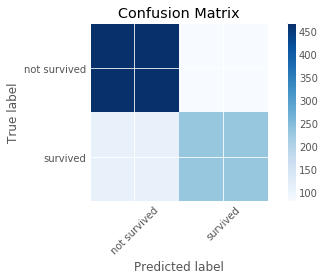

In [21]:
# 混同行列をグラフで表示
# 真陽性(True Positive) 偽陰性(False Negative)
# 偽陽性(False Positive) 真陰性(True Negative)
def plot_confusion_matrix(cm):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title('Confusion Matrix')
    fig.colorbar(im)

    target_names = ['not survived', 'survived']

    tick_marks = np.arange(len(target_names))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(target_names, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(target_names)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    fig.tight_layout()

plot_confusion_matrix(cm)

In [23]:
# トレーニングデータと同様に、Kaggleに投稿するテストデータからも生存者を推定しましょう。
x_test = df_test['Sex']
y_test_pred = x_test.map({'female': 1, 'male': 0}).astype(int)

In [26]:
# Kaggleに投稿するファイルを生成
df_kaggle = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': np.array(y_test_pred)})
df_kaggle.to_csv('kaggle_gendermodel.csv', index=False)

In [25]:
df_kaggle.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## 4. ロジスティック回帰による生存者推定

In [28]:
# 年齢、Pクラス、性別を使う
X = df_train[['Age', 'Pclass', 'Sex']]
y = df_train['Survived']
X.tail()

,Age,Pclass,Sex
886,27.0,2,male
887,19.0,1,female
888,NaN,3,female
889,26.0,1,male
890,32.0,3,male


In [29]:
# 年齢の欠損値を埋める
X['AgeFill'] = X['Age'].fillna(X['Age'].mean())
X = X.drop(['Age'], axis=1)
# 以下でも同じ
# X['Age'] = X['Age'].fillna(X['Age'].mean())

In [31]:
# 性別を数値にする
# 2つしか値がないから0, 1にしている
X['Gender'] = X['Sex'].map({'female': 0, 'male': 1}).astype(int)
X.tail()

,Pclass,Sex,AgeFill,Gender
886,2,male,27.000000,1
887,1,female,19.000000,0
888,3,female,29.699118,0
889,1,male,26.000000,1
890,3,male,32.000000,1


In [32]:
# 女性（Gender=0）で且つ、乗船クラスのランクが高い（Pclass=1）ほど、生存率が高いという仮説を表す新しい特徴量（Pclass_Gender）を作成する
# Pclass_Genderは値が小さいほど生存率が高いことになる
X['Pclass_Gender'] = X['Pclass'] + X['Gender']
X.tail()

,Pclass,Sex,AgeFill,Gender,Pclass_Gender
886,2,male,27.000000,1,3
887,1,female,19.000000,0,1
888,3,female,29.699118,0,3
889,1,male,26.000000,1,2
890,3,male,32.000000,1,4


In [33]:
# 今回は特徴量としてPclass_GenderとAgeの2つを使うので、不要な特徴量を drop する
X = X.drop(['Pclass', 'Sex', 'Gender'], axis=1)
X.tail()

,AgeFill,Pclass_Gender
886,27.000000,3
887,19.000000,1
888,29.699118,3
889,26.000000,2
890,32.000000,4


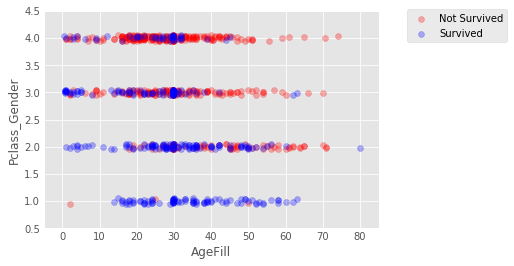

In [41]:
# 横軸が年齢、縦軸がPclass_Genderのグラフを描く
np.random.seed = 0

xmin, xmax = -5, 85
ymin, ymax = 0.5, 4.5

index_survived = y[y==0].index
index_notsurvived = y[y==1].index

fig, ax = plt.subplots()
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
sc = ax.scatter(X.loc[index_survived, 'AgeFill'],
                X.loc[index_survived, 'Pclass_Gender'] + (np.random.rand(len(index_survived))-0.5)*0.1,
                color='r', label='Not Survived', alpha=0.3)
sc = ax.scatter(X.loc[index_notsurvived, 'AgeFill'],
                X.loc[index_notsurvived, 'Pclass_Gender'] + (np.random.rand(len(index_notsurvived))-0.5)*0.1,
                color='b', label='Survived', alpha=0.3)
ax.set_xlabel('AgeFill')
ax.set_ylabel('Pclass_Gender')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.legend(bbox_to_anchor=(1.4, 1.03))
plt.show()

### トレーニングデータの分割

In [46]:
# 80%のトレーニングデータ、20%のテストデータに分割
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=1)

In [47]:
print('Num of Training Samples: {}'.format(len(X_train)))
print('Num of Validation Samples: {}'.format(len(X_val)))

Num of Training Samples: 712
Num of Validation Samples: 179


### ロジスティック回帰による推定

In [48]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [49]:
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)

In [52]:
# 結果を評価
print('Accuracy on Training Set: {:.3f}'.format(accuracy_score(y_train, y_train_pred)))
print('Accuracy on Validation Set: {:.3f}'.format(accuracy_score(y_val, y_val_pred)))

Accuracy on Training Set: 0.774
Accuracy on Validation Set: 0.760


In [53]:
# 混同行列を表示
cm = confusion_matrix(y_val, y_val_pred)
print(cm)

[[93 13]
 [30 43]]


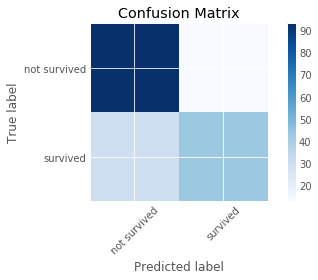

In [54]:
plot_confusion_matrix(cm)

In [56]:
print(classification_report(y_val, y_val_pred))

             precision    recall  f1-score   support

          0       0.76      0.88      0.81       106
          1       0.77      0.59      0.67        73

avg / total       0.76      0.76      0.75       179



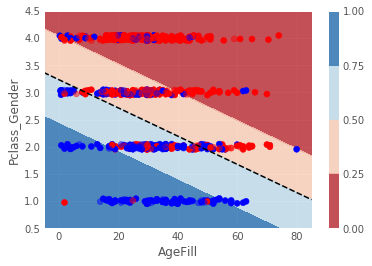

In [58]:
h = 0.02
xmin, xmax = -5, 85
ymin, ymax = 0.5, 4.5
xx, yy = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots()
levels = np.linspace(0, 1.0, 5)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
contour = ax.contourf(xx, yy, Z, cmap=cm, levels=levels, alpha=0.8)
ax.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1]+(np.random.rand(len(X_train))-0.5)*0.1, c=y_train, cmap=cm_bright)
ax.scatter(X_val.iloc[:, 0], X_val.iloc[:, 1]+(np.random.rand(len(X_val))-0.5)*0.1, c=y_val, cmap=cm_bright, alpha=0.5)
ax.set_xlabel('AgeFill')
ax.set_ylabel('Pclass_Gender')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
fig.colorbar(contour)

x1 = xmin
x2 = xmax
y1 = -1*(clf.intercept_[0]+clf.coef_[0][0]*xmin)/clf.coef_[0][1]
y2 = -1*(clf.intercept_[0]+clf.coef_[0][0]*xmax)/clf.coef_[0][1]
ax.plot([x1, x2] ,[y1, y2], 'k--')

plt.show()

In [59]:
# サポートベクターマシン使ってみる
clf_svc_lin = SVC(kernel='linear', probability=True)
clf_svc_lin.fit(X_train, y_train)
y_train_svc_pred = clf_svc_lin.predict(X_train)
y_val_svc_pred = clf_svc_lin.predict(X_val)
print('Accuracy on Training Set: {:.3f}'.format(accuracy_score(y_train, y_train_svc_pred)))
print('Accuracy on Validation Set: {:.3f}'.format(accuracy_score(y_val, y_val_svc_pred)))

Accuracy on Training Set: 0.779
Accuracy on Validation Set: 0.760


[[92 14]
 [29 44]]


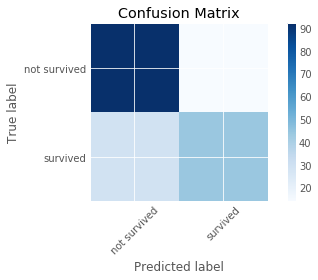

In [60]:
cm_svc = confusion_matrix(y_val, y_val_svc_pred)
print(cm_svc)
plot_confusion_matrix(cm_svc)

In [61]:
print(classification_report(y_val, y_val_svc_pred))

             precision    recall  f1-score   support

          0       0.76      0.87      0.81       106
          1       0.76      0.60      0.67        73

avg / total       0.76      0.76      0.75       179



## 5. 交差検証（クロスバリデーション）